In [1]:
import os
import math
import numpy as np 
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import norm
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import pickle
from sklearn.externals import joblib
plt.rcParams['font.family'] = 'AppleGothic'

C:\Users\gudfl\Anaconda3\envs\tf_env\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# 파일시스템으로부터 데이터 파일 읽기
primitive_df = pd.read_csv(os.path.relpath('./train_data.csv'), index_col='id')

In [3]:
# 데이터 병합
# primitive_df = pd.concat([primitive_df, dist_hangang, dist_station, dist_hospital], axis=1)

In [4]:
# 잉여 feature 삭제
train_df = primitive_df.drop([ 
            'exclusivePyeong', 
            'supplyPyeong', 
            'pyeongNo', 
            'complexName.1', 
            'completionMonth',
            'roadAddress.1', 
            'rentCount', 
            'dealCount', 
            'cortarNo'], axis=1)

In [5]:
train_df.columns

Index(['detailAddress', 'complexName', 'exclusiveArea', 'contactDate', 'price',
       'floor', 'constructYear', 'roadAddress', 'complexNo', 'supplyArea',
       'householdCountByPyeong', 'realEstateTypeCode', 'exclusiveRate',
       'entranceType', 'roomCnt', 'bathroomCnt', 'latitude', 'longitude',
       'totalHouseholdCount', 'totalLeaseHouseholdCount', 'highFloor',
       'lowFloor', 'totalDongCount', 'maxSupplyArea', 'minSupplyArea',
       'batlRatio', 'btlRatio', 'parkingCountByHousehold',
       'constructionCompanyName', 'heatMethodTypeCode', 'heatFuelTypeCode',
       'address', 'distHangang', 'distStation', 'distHospital'],
      dtype='object')

In [6]:
# 모든 숫자형 컬럼에 대해서 0 -> NaN으로 변경
def replaceZeroToNull(x):
    if x == 0:
        return None
    return x

numeric_cols = train_df.select_dtypes(include=[np.number]).columns.to_list()

for col in numeric_cols:
    train_df[col] = train_df[col].apply(lambda x: replaceZeroToNull(x))

# contactDate컬럼 타입 변경 (string -> Date)
train_df['contactDate'] = train_df['contactDate'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

In [7]:
# brand열: 건설회사
def cleanBrand(raw):
    if pd.isnull(raw):
        return '기타'
    
    raw = raw.split(',')[0]
    raw = raw.split('외')[0]
    raw = raw.replace('(주)', '')
    raw = raw.replace('쭈', '')
    raw = raw.replace('(', '')
    raw = raw.replace(')', '')
    raw = raw.replace('', '')
    raw = raw.replace('M&C', '')
    raw = raw.replace('㈜', '')
    raw = raw.replace('주식회사', '')
    raw = raw.replace('주식회서', '')
    raw = raw.replace('건설', '')
    raw = raw.replace('종합', '')
    raw = raw.replace('종합', '')
    raw = raw.strip()
    raw = raw.split(' ')[0]

    return raw

train_df['brand'] = train_df['constructionCompanyName'].apply(cleanBrand)

In [8]:
# 데이터상에서 100회 이하로 언급되는 건설회사 -> 기타로 취급
brands = train_df['brand'].value_counts() > 100

noNamedBrands = []
for brand, isNamed in zip(brands.index, brands.values):
    if not isNamed:
        noNamedBrands.append(brand)
        
def extendEtc(name):
    if name in noNamedBrands:
        return '기타'
    return name

train_df['brand'] = train_df['brand'].apply(extendEtc)

train_df.drop('constructionCompanyName', axis=1, inplace=True)

In [9]:
# contactDay열: 2000년 1월 1일을 기준으로 계약일까지의 일 수
critia_date = datetime.datetime(2000, 1, 1)
def date2Mon(date):
    return (date - critia_date).days

train_df['contactDay'] = train_df['contactDate'].apply(date2Mon)
train_df.drop('contactDate', axis=1, inplace=True)

In [10]:
# volume열: 단지별 역대 거래량
volume_dict = train_df.groupby('complexName').count()['price'].to_dict()

train_df['volume'] = train_df['complexName'].apply(lambda x: volume_dict[x])

In [11]:
pd.Series(volume_dict).to_csv('volume.csv')

In [12]:
# floorRate열: 매물의 층과 전체 아파트 층과의 비율 
train_df['floorRate'] = train_df['floor'] / ((train_df['highFloor'] + train_df['lowFloor'])*0.8)

In [13]:
train_df.sort_values(by=['complexNo', 'supplyArea', 'contactDay'], inplace=True, ascending=False)
train_df.reset_index(drop=True, inplace=True)

In [14]:
train_df['recentContactDay'] = 0
train_df['recentFloorRate'] = 0.0
train_df['recentPrice'] = 0

In [15]:
def recent_trade(i):
    if not(0<=i and i<len(train_df)-1):
        return
    cor_data = train_df.loc[i]
    next_data = train_df.loc[i+1]
    if next_data.supplyArea != cor_data.supplyArea:
        return
    
    train_df.at[i, 'recentContactDay'] = next_data['contactDay']
    train_df.at[i, 'recentFloorRate'] = next_data['floorRate']
    train_df.at[i, 'recentPrice'] = next_data['price']
    
    return

In [16]:
for i in range(len(train_df)):
    recent_trade(i)

In [17]:
(train_df['recentContactDay'] == 0).value_counts()

False    891651
True      26257
Name: recentContactDay, dtype: int64

In [18]:
recent_train_df = train_df[['recentContactDay', 'recentFloorRate', 'recentPrice']]
#train_df.drop(['recentContactDay', 'recentFloorRate', 'recentPrice'], axis=1, inplace=True)

In [19]:
train_df.drop('complexNo', axis=1, inplace=True)

In [20]:
# 숫자형 컬럼
numeric_features = train_df.select_dtypes(include=[np.number])
numeric_features.dtypes

exclusiveArea               float64
price                         int64
floor                         int64
constructYear                 int64
supplyArea                  float64
householdCountByPyeong      float64
exclusiveRate               float64
roomCnt                     float64
bathroomCnt                 float64
latitude                    float64
longitude                   float64
totalHouseholdCount         float64
totalLeaseHouseholdCount    float64
highFloor                   float64
lowFloor                    float64
totalDongCount              float64
maxSupplyArea               float64
minSupplyArea               float64
batlRatio                   float64
btlRatio                    float64
parkingCountByHousehold     float64
distHangang                 float64
distStation                 float64
distHospital                float64
contactDay                    int64
volume                        int64
floorRate                   float64
recentContactDay            

In [21]:
# 객체형 컬럼
categorical_features = train_df.select_dtypes(include=[np.object])
categorical_features.dtypes

detailAddress         object
complexName           object
roadAddress           object
realEstateTypeCode    object
entranceType          object
heatMethodTypeCode    object
heatFuelTypeCode      object
address               object
brand                 object
dtype: object

Price Skew:  3.073036727586035
Price Kurtosis: 16.938954


findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


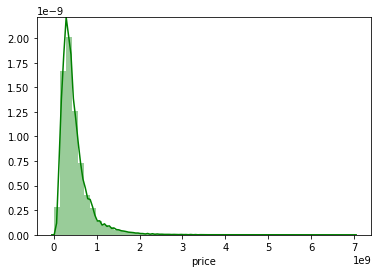

In [22]:
# 종속변수 편향도 & 첨도
print("Price Skew: ", train_df.price.skew())
print("Price Kurtosis: %f" % train_df.price.kurt())

sns.distplot(train_df.price, color='green')
plt.show()

Price Skew:  0.20854499117699452
Price Kurtosis: 0.397525


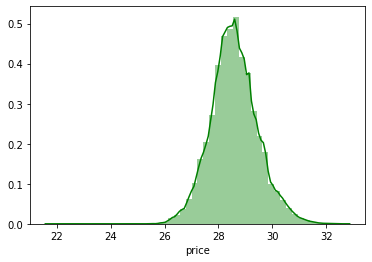

In [23]:
log_price = np.log2(train_df.price)

print("Price Skew: ", log_price.skew())
print("Price Kurtosis: %f" % log_price.kurt())

sns.distplot(log_price, color='green')
plt.show()

In [24]:
# 종속변수 - 독립변수 상관관계
corr = numeric_features.corr()
print (corr['price'].sort_values(ascending=False))

price                       1.000000
recentPrice                 0.941077
supplyArea                  0.632824
exclusiveArea               0.625868
maxSupplyArea               0.558831
roomCnt                     0.483377
parkingCountByHousehold     0.443086
minSupplyArea               0.420308
bathroomCnt                 0.400842
contactDay                  0.326815
highFloor                   0.310397
recentContactDay            0.290113
exclusiveRate               0.267785
totalDongCount              0.213224
lowFloor                    0.185907
floor                       0.167966
totalHouseholdCount         0.126119
constructYear               0.112030
longitude                   0.087322
householdCountByPyeong      0.014086
floorRate                   0.009543
batlRatio                  -0.006186
recentFloorRate            -0.007529
distHospital               -0.071147
volume                     -0.079598
btlRatio                   -0.105178
distStation                -0.109501
d

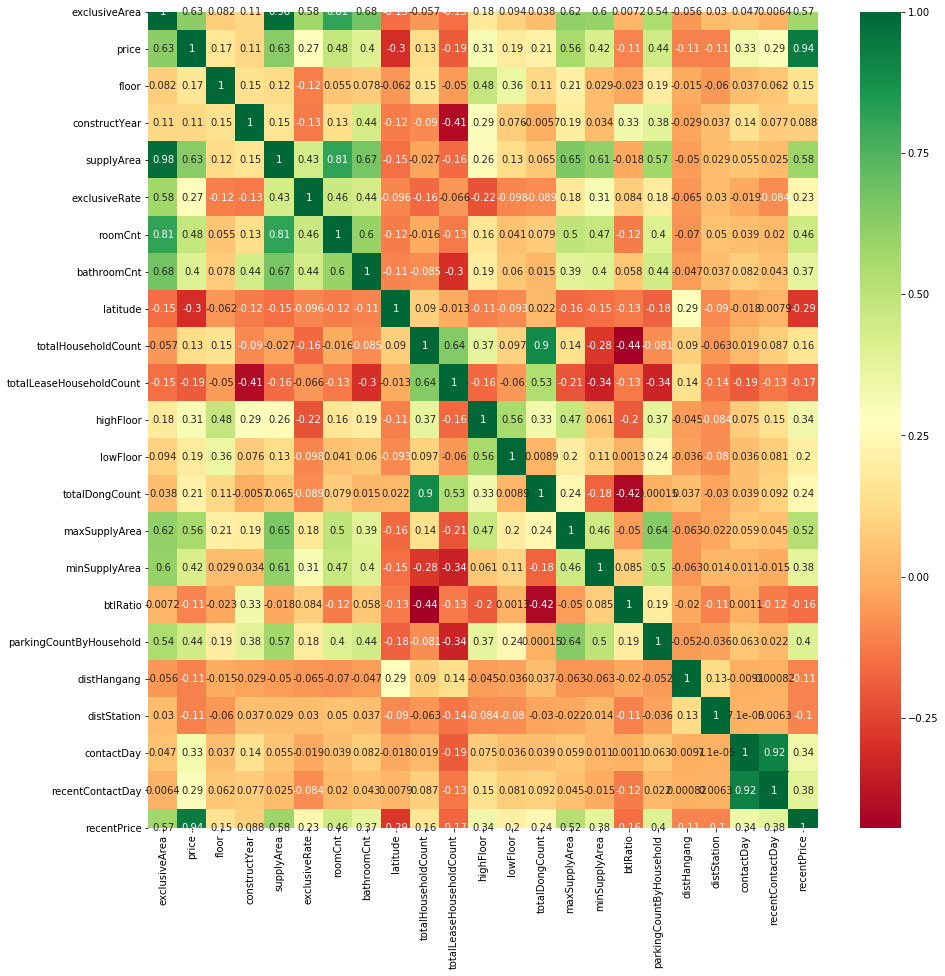

In [25]:
# 히트맵 시각화
corrmat = train_df.corr()
top_corr_features = corrmat.index[abs(corrmat['price']) > 0.1]
plt.figure(figsize=(15, 15))
g = sns.heatmap(train_df[top_corr_features].corr(), annot=True, cmap="RdYlGn")

# supplyArea와 exclusiveArea의 상관계수가 0.98으로 상관관계가 매우 높다(매우 당연하다...!)
# totalDongCount와 totalHouseholdCount의 상관계수가 0.9로 높다

In [26]:
# 상관계수가 높은 컬럼(totalHouseholdCount, exclusiveArea) 삭제
train_df.drop(['totalHouseholdCount', 'exclusiveArea'], axis=1, inplace=True)

In [27]:
# 컬럼별 결측치 비율
train_df.isnull().sum()/train_df.shape[0]*100

detailAddress                0.000000
complexName                  0.000000
price                        0.000000
floor                        0.000000
constructYear                0.000000
roadAddress                  0.000000
supplyArea                   0.000000
householdCountByPyeong       0.001634
realEstateTypeCode           0.000000
exclusiveRate                0.000000
entranceType                 0.000000
roomCnt                      0.021026
bathroomCnt                  0.021026
latitude                     0.000000
longitude                    0.000000
totalLeaseHouseholdCount    91.900169
highFloor                    0.000000
lowFloor                     0.000000
totalDongCount               0.001089
maxSupplyArea                0.000000
minSupplyArea                0.015688
batlRatio                    4.860073
btlRatio                    10.344937
parkingCountByHousehold      4.634125
heatMethodTypeCode           0.041725
heatFuelTypeCode             0.039546
address     

In [28]:
# 결측치가 너무 많은 totalLeaseHouseholdCount, btlRatio, parkingCountByHousehold, batlRatio열 삭제
train_df.drop(['totalLeaseHouseholdCount', 'btlRatio', 'parkingCountByHousehold', 'batlRatio'], axis=1, inplace=True)

In [29]:
# 레코드 중 NaN이 있는 레코드 개수(False)
(train_df.isnull().sum(1) == 0).value_counts()

True     916800
False      1108
dtype: int64

In [30]:
# 결측값이 있는 행 삭제
train_df.dropna(inplace=True)

In [31]:
# 컬럼별 결측값 개수
train_df.isnull().sum()

# 결측값이 모두 제거됨

detailAddress             0
complexName               0
price                     0
floor                     0
constructYear             0
roadAddress               0
supplyArea                0
householdCountByPyeong    0
realEstateTypeCode        0
exclusiveRate             0
entranceType              0
roomCnt                   0
bathroomCnt               0
latitude                  0
longitude                 0
highFloor                 0
lowFloor                  0
totalDongCount            0
maxSupplyArea             0
minSupplyArea             0
heatMethodTypeCode        0
heatFuelTypeCode          0
address                   0
distHangang               0
distStation               0
distHospital              0
brand                     0
contactDay                0
volume                    0
floorRate                 0
recentContactDay          0
recentFloorRate           0
recentPrice               0
dtype: int64

In [32]:
# 데이터 처리 후 상관관계
numeric_features = train_df.select_dtypes(include=[np.number])
corr = numeric_features.corr()
print (corr['price'].sort_values(ascending=False))

price                     1.000000
recentPrice               0.941067
supplyArea                0.633103
maxSupplyArea             0.558767
roomCnt                   0.483339
minSupplyArea             0.420669
bathroomCnt               0.400772
contactDay                0.326768
highFloor                 0.310321
recentContactDay          0.290072
exclusiveRate             0.267291
totalDongCount            0.213164
lowFloor                  0.185811
floor                     0.167955
constructYear             0.112146
longitude                 0.087319
householdCountByPyeong    0.014006
floorRate                 0.009627
recentFloorRate          -0.007457
distHospital             -0.071092
volume                   -0.079653
distStation              -0.109830
distHangang              -0.111102
latitude                 -0.303749
Name: price, dtype: float64


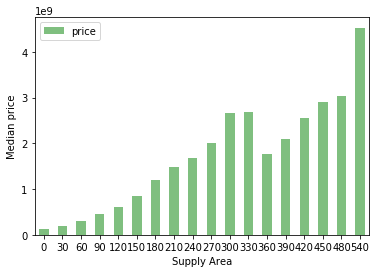

In [33]:
supply_area_range = train_df['supplyArea'].apply(lambda x: int(x/30)*30)
quality_pivot = train_df.pivot_table(index=supply_area_range, values='price', aggfunc=np.median)
quality_pivot.plot(kind='bar', color='green', alpha = 0.5)
plt.xlabel('Supply Area')
plt.ylabel('Median price')
plt.xticks(rotation=0)
plt.show()

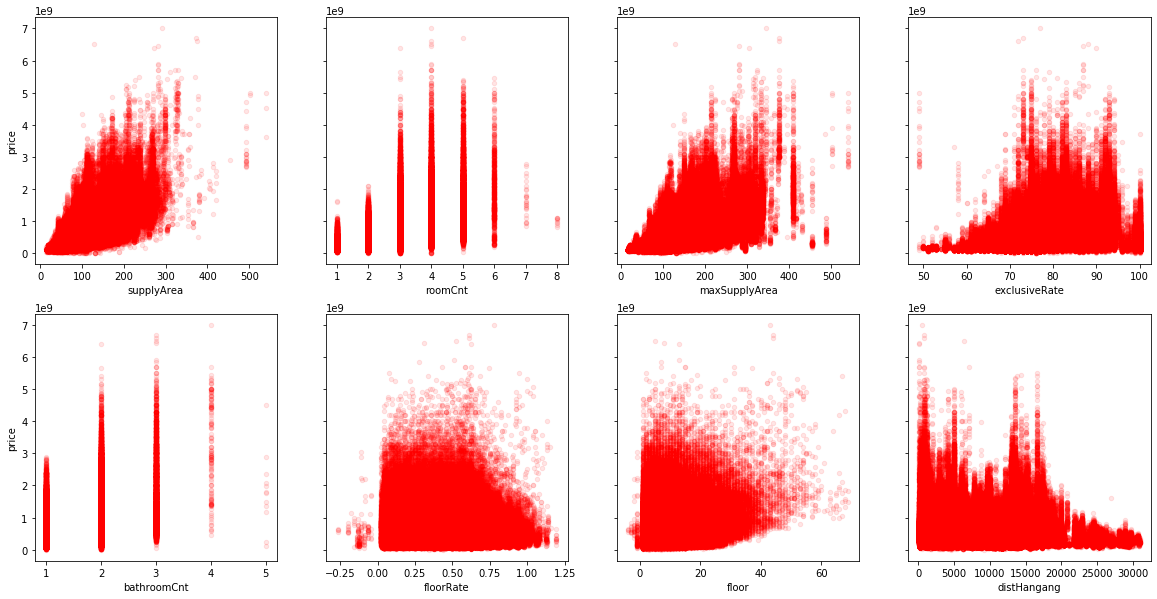

In [34]:
# 주요 컬럼 시각화
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
axes = np.ravel(axes)
col_name = ['supplyArea','roomCnt','maxSupplyArea','exclusiveRate', 'bathroomCnt', 'floorRate', 'floor', 'distHangang']
for i, c in zip(range(len(col_name)), col_name):
    train_df.plot.scatter(ax=axes[i], x=c, y='price', sharey=True, colorbar=False, color='red', alpha = 0.1)   

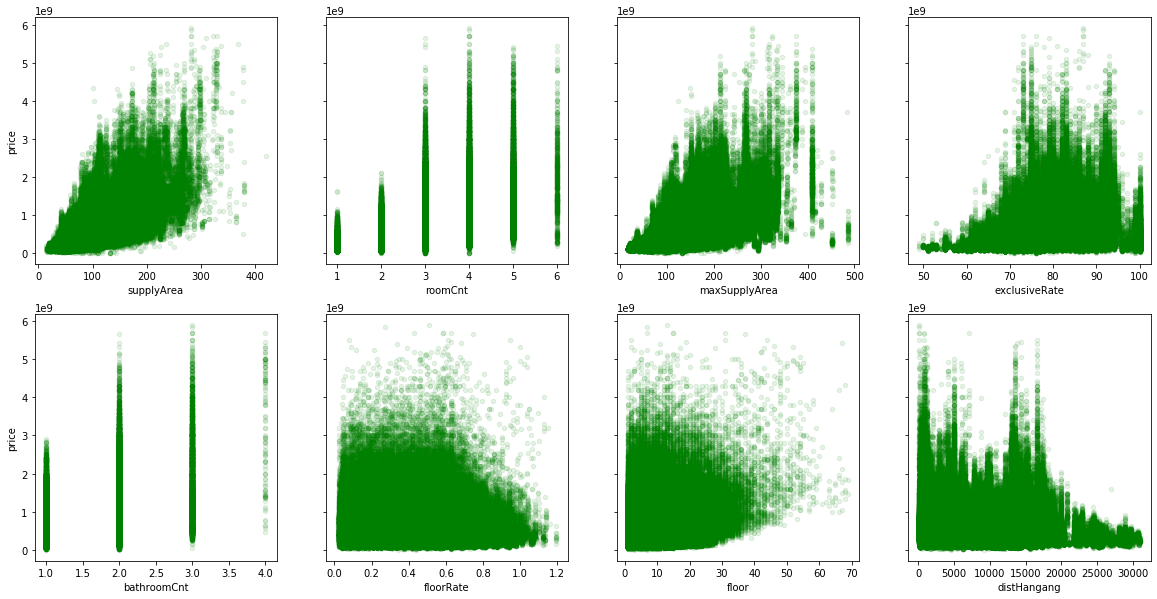

In [35]:
# 이상치 제거
train_df = train_df[train_df['price'] < 6000000000]
train_df = train_df[train_df['supplyArea'] < 450]
train_df = train_df[train_df['roomCnt'] < 7]
train_df = train_df[train_df['maxSupplyArea'] < 500]
train_df = train_df[(train_df['exclusiveRate']>60) | (train_df['price']<1000000000)]
train_df = train_df[train_df['bathroomCnt'] < 5]
train_df = train_df[train_df['floorRate'] >= 0]

fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
axes = np.ravel(axes)
for i, c in zip(range(len(col_name)), col_name):
    train_df.plot.scatter(ax=axes[i], x=c, y='price', sharey=True, colorbar=False, color='green', alpha = 0.1)   

In [36]:
# 카테고리형 컬럼 
categoricals = train_df.select_dtypes(exclude=[np.number])

for c in categoricals.columns:
    print('{:<14}'.format(c), train_df[c].unique())

detailAddress  ['457-1' '313' '400-60' ... '628-15' '691-1' '676-5']
complexName    ['청송평화' '신주아파트(313)' '은하(400-60)' ... '신송타워' '부영' '등촌라인(조합)']
roadAddress    ['곰달래로35길 86' '천중로11길 24' '가로공원로 221' ... '공항대로39길 100' '서울숲길 25'
 '서울숲길 34']
realEstateTypeCode ['A01' 'A03']
entranceType   ['계단식' '복합식' '복도식']
heatMethodTypeCode ['HT001' 'HT005' 'HT002' 'HT003']
heatFuelTypeCode ['HF001' 'HF002' 'HF004' 'HF007' 'HF003']
address        ['서울시 강서구 화곡동' '서울시 강동구 천호동' '서울시 강북구 미아동' '서울시 도봉구 창동' '서울시 양천구 신월동'
 '서울시 광진구 자양동' '서울시 은평구 대조동' '서울시 송파구 송파동' '서울시 서초구 양재동' '서울시 동대문구 장안동'
 '서울시 서초구 서초동' '서울시 광진구 구의동' '서울시 서초구 우면동' '서울시 서초구 방배동' '서울시 구로구 구로동'
 '서울시 은평구 갈현동' '서울시 동작구 상도1동' '서울시 은평구 구산동' '서울시 은평구 역촌동' '서울시 도봉구 쌍문동'
 '서울시 용산구 후암동' '서울시 양천구 목동' '서울시 은평구 응암동' '서울시 송파구 석촌동' '서울시 송파구 마천동'
 '서울시 동작구 상도동' '서울시 성동구 하왕십리동' '서울시 금천구 독산동' '서울시 관악구 남현동' '서울시 구로구 오류동'
 '서울시 중랑구 중화동' '서울시 강북구 수유동' '서울시 동작구 노량진동' '서울시 용산구 효창동' '서울시 동대문구 이문동'
 '서울시 종로구 부암동' '서울시 광진구 중곡동' '서울시 송파구 가락동' '서울시 동대문구 휘경동' '서울시 송파

In [38]:
# 학습에 쓸모없는 열 삭제
train_df.drop(['detailAddress', 'complexName', 'roadAddress'], axis=1, inplace=True)

In [39]:
train_df.to_csv("statis.csv")

In [40]:
# 카테고리형 컬럼 원핫인코딩
columns = train_df.select_dtypes(exclude=[np.number]).columns

for c in columns:
    oh_df = pd.get_dummies(train_df[c])
    train_df = pd.concat([train_df, oh_df], axis=1)
    train_df.drop(c, axis=1)

train_df.shape

(916557, 841)

In [41]:
# 원핫인코딩한 열 삭제
train_df.drop(columns, axis=1, inplace=True)

In [42]:
# 피처/레이블 분리
X = train_df.drop('price', axis=1)
y = train_df['price']

columns = X.columns.to_list()

In [43]:
# 피쳐 추출용 머신러닝 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [44]:
recent_train_df = X_train[['recentContactDay', 'recentFloorRate', 'recentPrice']]
X_train.drop(['recentContactDay', 'recentFloorRate', 'recentPrice'], axis=1, inplace=True)

recent_test_df = X_test[['recentContactDay', 'recentFloorRate', 'recentPrice']]
X_test.drop(['recentContactDay', 'recentFloorRate', 'recentPrice'], axis=1, inplace=True)

In [57]:
recent_train_df.to_csv("recent_train_df.csv")
recent_test_df.to_csv("recent_test_df.csv")

In [56]:
X_train

,supplyArea,householdCountByPyeong,exclusiveRate,roomCnt,bathroomCnt,latitude,longitude,highFloor,lowFloor,constructYear,...,HT005,A01,A03,volume,contactDay,floor,floorRate,distHangang,distStation,distHospital
29355,76.17,1.0,83.0,3.0,2.0,37.600941,126.921956,6.0,6.0,2007,...,0,1,0,17,3307,6,0.625000,6476.74,570.18,2217.17
203483,58.45,33.0,61.0,2.0,1.0,37.481223,126.950306,18.0,18.0,1998,...,0,0,1,187,3475,10,0.347222,3502.66,213.40,1605.34
7725,39.61,3.0,80.0,2.0,1.0,37.497601,127.134419,8.0,8.0,2015,...,0,0,1,3,6360,8,0.625000,7868.85,72.24,975.77
499960,84.33,207.0,71.0,3.0,1.0,37.575245,126.960297,23.0,10.0,2000,...,0,1,0,11957,2665,1,0.037879,4785.01,226.65,248.50
185277,53.61,401.0,69.0,2.0,1.0,37.486514,126.890371,21.0,9.0,2006,...,0,1,0,797,7209,12,0.500000,25741.84,275.89,800.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492377,120.41,134.0,71.0,3.0,2.0,37.500111,126.890452,24.0,24.0,1996,...,0,0,1,308,6377,17,0.442708,25164.00,785.78,1006.17
792967,102.58,923.0,83.0,3.0,2.0,37.657333,127.026348,15.0,9.0,1994,...,0,1,0,859,6494,9,0.468750,15879.60,1216.90,1246.05
472038,46.41,476.0,74.0,2.0,1.0,37.565331,126.855765,15.0,15.0,1992,...,1,1,0,2017,2735,8,0.333333,254.53,439.75,1031.37
492969,74.67,143.0,80.0,2.0,1.0,37.502521,126.891859,24.0,24.0,1995,...,0,1,0,297,5640,17,0.442708,5747.50,721.60,1159.76


In [45]:
# 피쳐 추출용 모델
# RandomForest
random_forest_regressor = RandomForestRegressor(n_estimators=100, n_jobs=-1)
random_forest_regressor = random_forest_regressor.fit(X_train, y_train)

# load model
# random_forest_regressor = joblib.load('./random_forest_regressor_for_extracting_feature.pkl') 

y_pred_rf = random_forest_regressor.predict(X_test)

print('The accuracy of the Random Forset is', r2_score(y_test,y_pred_rf))
print ('RMSE is: ', mean_squared_error(y_test, y_pred_rf)**0.5)
print('\n')

The accuracy of the Random Forset is 0.9804540882040902
RMSE is:  45663963.49415912




In [46]:
# save model
#joblib.dump(random_forest_regressor, 'random_forest_regressor_for_extracting_feature.pkl') 

In [47]:
xxx = joblib.load('random_forest_regressor_for_extracting_feature.pkl') 
p = xxx.predict(X_test)

print('The accuracy of the Random Forset is', r2_score(y_test,p))
print ('RMSE is: ', mean_squared_error(y_test, p)**0.5)
print('\n')

The accuracy of the Random Forset is 0.9803180038906879
RMSE is:  45822650.65329759




In [61]:
# 피처 중요도
feature_importance = xxx.feature_importances_
threshold_fi = 0.0001

df_fi = pd.DataFrame({'columns':X_train.columns, 'importances':feature_importance})
df_fi = df_fi[df_fi['importances'] > threshold_fi] # importance가 0.0001이상인 것만 
df_fi = df_fi.sort_values(by=['importances'], ascending=False)

fig = plt.figure(figsize=(15,7))
ax = sns.barplot(df_fi['columns'], df_fi['importances'])
ax.set_xticklabels(df_fi['columns'], rotation=80, fontsize=13)
plt.tight_layout()
plt.show()
print(df_fi[df_fi['importances'] > threshold_fi])

776
779


ValueError: arrays must all be same length

In [50]:
# 중요도가 0.0001 이상인 열만 추출
importantFeatures = df_fi[df_fi['importances'] > threshold_fi]['columns'].to_list()

train_df_fi = X[importantFeatures]

print(len(importantFeatures))

In [64]:
importantFeatures

['supplyArea',
 'contactDay',
 'latitude',
 'longitude',
 'HF002',
 'constructYear',
 'HT005',
 'maxSupplyArea',
 'totalDongCount',
 'distHangang',
 '서울시 강남구 압구정동',
 'HT001',
 'lowFloor',
 'distStation',
 'volume',
 'distHospital',
 'minSupplyArea',
 'highFloor',
 'HF001',
 'householdCountByPyeong',
 'floorRate',
 'exclusiveRate',
 '서울시 강남구 대치동',
 'floor',
 '서울시 서초구 잠원동',
 '계단식',
 'bathroomCnt',
 'roomCnt',
 '서울시 관악구 봉천동',
 '서울시 강남구 도곡동',
 '서울시 마포구 상암동',
 '서울시 노원구 중계동',
 '서울시 서초구 반포동',
 '서울시 강남구 청담동',
 '서울시 성동구 성수동1가',
 '서울시 용산구 이촌동',
 '서울시 서초구 방배동',
 '삼성물산',
 '서울시 강남구 삼성동',
 '동양고속',
 '기타',
 '우성',
 'HT002',
 '대림산업',
 '복도식',
 '계룡산업',
 'A03',
 '서울시 종로구 내수동',
 '서울시 양천구 목동',
 '롯데',
 '서울시 종로구 사직동',
 'A01',
 '현대',
 '서울시 성북구 길음동',
 '서울시 종로구 명륜2가',
 '한양',
 '한신공영',
 '현대산업개발',
 '서울시 서초구 서초동',
 '복합식',
 '서울시 영등포구 여의도동',
 '대우',
 '쌍용',
 '서울시 중구 장충동1가',
 '선경',
 '서울시 강남구 개포동',
 '삼성중공업']

In [54]:
train_df_fi.to_csv("X_train.csv")
y.to_csv("y_train.csv")

In [58]:
# 머신러닝 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(train_df_fi, y, test_size = 0.2, random_state=1)

In [52]:
print(X_train.head(1))
print(X_train.shape)

       supplyArea  householdCountByPyeong  exclusiveRate  roomCnt  \
29355       76.17                     1.0           83.0      3.0   

       bathroomCnt   latitude   longitude  highFloor  lowFloor  constructYear  \
29355          2.0  37.600941  126.921956        6.0       6.0           2007   

       ...  HT005  A01  A03  volume  contactDay  floor  floorRate  \
29355  ...      0    1    0      17        3307      6      0.625   

       distHangang  distStation  distHospital  
29355      6476.74       570.18       2217.17  

[1 rows x 66 columns]
(733245, 66)


In [53]:
# 파라미터 튜닝용 머신러닝 모델

In [60]:
# RandomForest 학습
random_forest_regressor = RandomForestRegressor(n_estimators=200, n_jobs=-1)
random_forest_regressor = random_forest_regressor.fit(X_train, y_train)
y_pred_rf = random_forest_regressor.predict(X_test)

print('The accuracy of the Random Forset is', r2_score(y_test,y_pred_rf))
print ('RMSE is: ', mean_squared_error(y_test, y_pred_rf)**0.5)
print('\n')

The accuracy of the Random Forset is 0.9805421724006314
RMSE is:  45560954.34730874




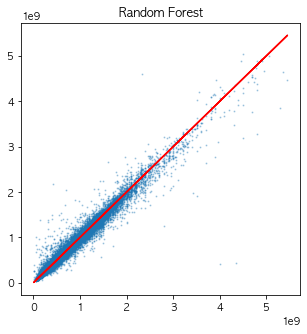

In [61]:
# Random Forest Result Visualization
fig = plt.figure(figsize=(5,5))
plt.scatter(y_test,y_pred_rf, alpha=0.3, s=1)
plt.plot(y_test,y_test,'r')
plt.title('Random Forest')
plt.show()

In [59]:
# DecisionTree 학습
decision_tree_regressor = DecisionTreeRegressor(max_depth=24, random_state=0)
decision_tree_regressor = decision_tree_regressor.fit(X_train, y_train)
y_pred_dt = decision_tree_regressor.predict(X_test)

print('The accuracy of the Decision Tree is',r2_score(y_test,y_pred_dt))
print ('RMSE is: ', mean_squared_error(y_test, y_pred_dt)**0.5)
print('\n')


The accuracy of the Decision Tree is 0.9681309708585015
RMSE is:  63849509.7654521




findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


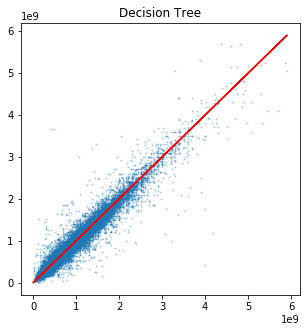

In [60]:
# Decision Tree Result Visualization
fig = plt.figure(figsize=(5,5))
plt.scatter(y_test,y_pred_dt, alpha=0.3, s=1)
plt.plot(y_test,y_test,'r')
plt.title('Decision Tree')
plt.show()

In [64]:
# XGBoost 학습
xgboost_regressor = XGBRegressor(max_depth=13)
xgboost_regressor = xgboost_regressor.fit(X_train, y_train)

y_pred_xgb = xgboost_regressor.predict(X_test)
print('The accuracy of the XGBoost is', r2_score(y_test,y_pred_xgb))
print ('RMSE is: ', mean_squared_error(y_test, y_pred_xgb)**0.5)
print('\n')

The accuracy of the XGBoost is 0.9808157467489492
RMSE is:  45239530.21435359




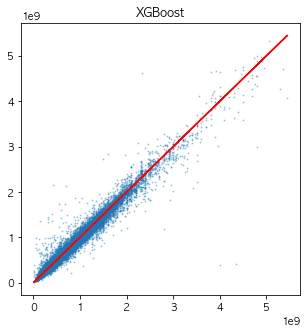

In [65]:
# XGBoost Result Visualization
fig = plt.figure(figsize=(5,5))
plt.scatter(y_test,y_pred_xgb, alpha=0.3, s=1)
plt.plot(y_test,y_test,'r')
plt.title('XGBoost')
plt.show()

In [73]:
rf_pred_df = pd.DataFrame(y_pred_rf, columns=['rf_pred'])
xgb_pred_df = pd.DataFrame(y_pred_xgb, columns=['xgb_pred'])
dt_pred_df = pd.DataFrame(y_pred_dt, columns=['dt_pred'])

In [82]:
second_train_df = pd.concat([recent_train_df, train_df[['contactDay', 'floorRate']], rf_pred_df, xgb_pred_df, dt_pred_df], axis=1)

In [85]:
print(second_train_df.head(3))
print(second_train_df.shape)
print(second_train_df.isnull().sum())

   recentContactDay  recentFloorRate  recentPrice  contactDay  floorRate  \
0              4503         0.555556    185000000         NaN        NaN   
1              3845        -0.138889    160000000      4503.0   0.555556   
2              2855         0.555556    163000000         NaN        NaN   

        rf_pred      xgb_pred       dt_pred  
0  8.102100e+07  7.759934e+07  8.027273e+07  
1  7.228450e+08  6.993519e+08  6.816667e+08  
2  1.096300e+09  1.097892e+09  1.100000e+09  
(792387, 8)
recentContactDay         0
recentFloorRate          0
recentPrice              0
contactDay            1139
floorRate             1139
rf_pred             634137
xgb_pred            634137
dt_pred             634137
dtype: int64


In [80]:
second_train_df.dropna(inplace=True)

In [81]:
print(second_train_df.head(3))
print(second_train_df.shape)

   recentContactDay  recentFloorRate  recentPrice  contactDay  floorRate  \
1              3845        -0.138889    160000000      4503.0   0.555556   
3              2473         0.277778    150000000      2855.0   0.555556   
4              2464         0.555556    158000000      2473.0   0.277778   

       rf_pred     xgb_pred       dt_pred  
1  722845000.0  699351936.0  6.816667e+08  
3  293757500.0  265316496.0  3.500000e+08  
4  399180000.0  394474720.0  4.740000e+08  
(157821, 8)


In [68]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error

def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    kf = StratifiedKFold(n_splits=n_folds, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n, y_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n.iloc[train_index]
        y_tr = y_train_n.iloc[train_index] 
        X_te = X_train_n.iloc[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [69]:
decision_tree_regressor = DecisionTreeRegressor(max_depth=24, random_state=0)
random_forest_regressor = RandomForestRegressor(n_estimators=200, n_jobs=-1)
xgboost_regressor = XGBRegressor(max_depth=13)

In [70]:
# CV스태킹 알고리즘 각 모델에 적용
rf_train, rf_test = get_stacking_base_datasets(random_forest_regressor, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(decision_tree_regressor, X_train, y_train, X_test,  7)    
xgb_train, xgb_test = get_stacking_base_datasets(xgboost_regressor, X_train, y_train, X_test, 7)

RandomForestRegressor  model 시작 


KeyboardInterrupt: 

In [94]:
# CV스태킹 알고리즘 결과로 메타 모델 학습/시험에 필요한 result_a result_b 만들기 
Stack_final_X_train = np.concatenate((rf_train, dt_train, xgb_train), axis=1)
Stack_final_X_test = np.concatenate((rf_test, dt_test, xgb_test), axis=1)

In [97]:
print(Stack_final_X_train.shape)
print(Stack_final_X_test.shape)

(632998, 3)
(158250, 3)


In [193]:
X_train_cf = X_train[['contactDay', 'floorRate']]
X_train_cf.reset_index(drop=True, inplace=True)
recent_train_df.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

X_test_cf = X_test[['contactDay', 'floorRate']]
X_test_cf.reset_index(drop=True, inplace=True)
recent_test_df.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [187]:
pred_X_train = pd.DataFrame(Stack_final_X_train, columns=['rf', 'dt', 'xgb'])
pred_X_test = pd.DataFrame(Stack_final_X_test, columns=['rf', 'dt', 'xgb'])

final_X_train = pd.concat([recent_train_df, X_train_cf, pred_X_train], axis=1)
final_X_test = pd.concat([recent_test_df, X_test_cf, pred_X_test], axis=1)

In [170]:
# 메타 모델 학습 1
metaModel = RandomForestRegressor(n_estimators=200, n_jobs=-1).fit(final_X_train, y_train)
y_pred = metaModel.predict(final_X_test)

In [171]:
print('The accuracy of the stacking ensemble is',r2_score(y_test,y_pred))
print ('RMSE is: ', mean_squared_error(y_test, y_pred)**0.5)
print('\n')

The accuracy of the stacking ensemble is 0.9822632404159021
RMSE is:  43499350.91722462




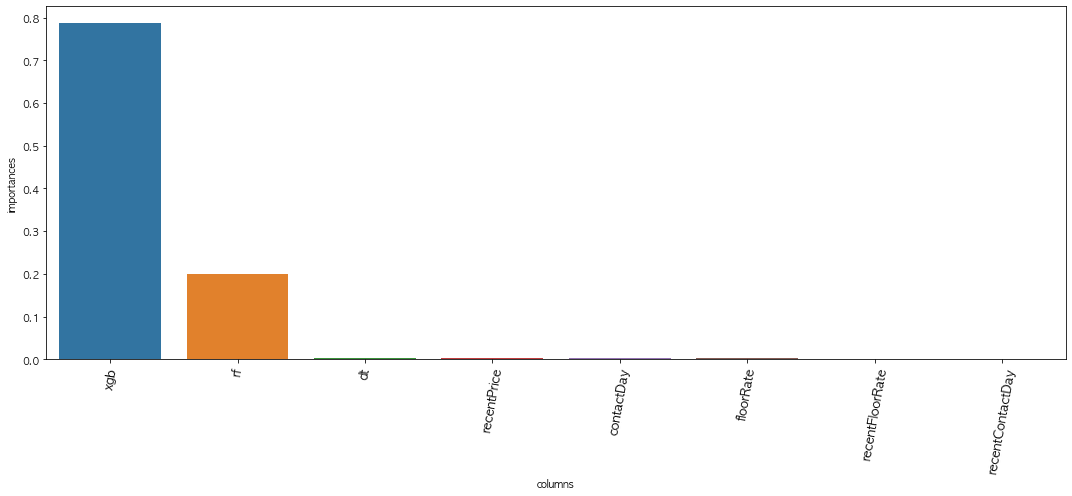

In [174]:
fi = metaModel.feature_importances_

df_fi = pd.DataFrame({'columns':final_X_train.columns, 'importances':fi})
df_fi = df_fi.sort_values(by=['importances'], ascending=False)

fig = plt.figure(figsize=(15,7))
ax = sns.barplot(df_fi['columns'], df_fi['importances'])
ax.set_xticklabels(df_fi['columns'], rotation=80, fontsize=13)
plt.tight_layout()
plt.show()

In [247]:
train_data = pd.concat([final_X_train, y_train], axis=1)
test_data = pd.concat([final_X_test, y_test], axis=1)

In [248]:
train_data = train_data[train_data['recentContactDay']!=0]
test_data = test_data[test_data['recentContactDay']!=0]

In [249]:
corr = train_data.corr()
print (corr['price'].sort_values(ascending=False))

price               1.000000
rf                  0.859860
xgb                 0.859188
dt                  0.853144
recentPrice         0.848767
contactDay          0.295570
recentContactDay    0.283650
floorRate           0.012190
recentFloorRate    -0.013803
Name: price, dtype: float64


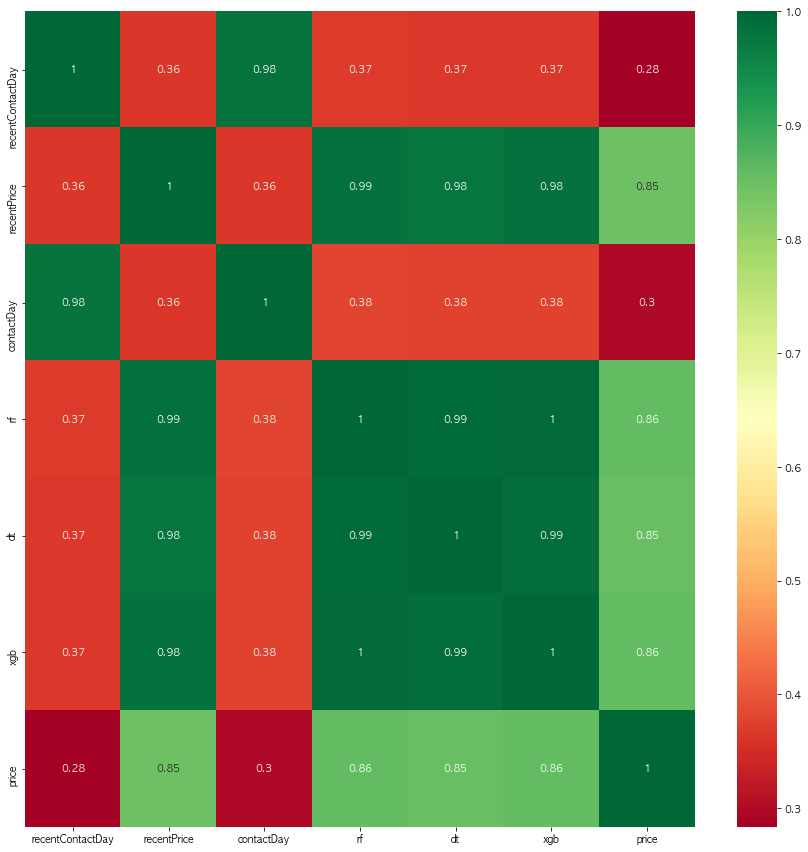

In [251]:
# 히트맵 시각화
corrmat = train_data.corr()
top_corr_features = corrmat.index[abs(corrmat['price']) > 0.1]
plt.figure(figsize=(15, 15))
g = sns.heatmap(train_data[top_corr_features].corr(), annot=True, cmap="RdYlGn")


In [241]:
train_data['recentPrice'] = np.log2(train_data['recentPrice'])
train_data['price'] = np.log2(train_data['price'])
train_data['rf'] = np.log2(train_data['rf'])
train_data['dt'] = np.log2(train_data['dt'])
train_data['xgb'] = np.log2(train_data['xgb'])


test_data['recentPrice'] = np.log2(test_data['recentPrice'])
test_data['price'] = np.log2(test_data['price'])
test_data['rf'] = np.log2(test_data['rf'])
test_data['dt'] = np.log2(test_data['dt'])
test_data['xgb'] = np.log2(test_data['xgb'])

train_data.dropna(inplace=True, axis=0)
test_data.dropna(inplace=True, axis=0)

In [ ]:
final_X_train = train_data.drop(['price'], axis=1)
final_X_test = test_data.drop(['price'], axis=1)
final_y_train = train_data['price']
final_y_test = test_data['price']

In [252]:
train_data

,recentContactDay,recentFloorRate,recentPrice,contactDay,floorRate,rf,dt,xgb,price
0,4078.0,0.219298,-1.922964,4143.0,0.328947,-1.937731,-1.980443,-1.940489,1400000000
1,6071.0,0.138889,-2.013345,6086.0,0.462963,-2.010300,-2.000849,-2.007320,498000000
2,2628.0,0.416667,-2.145236,2630.0,0.128205,-2.168302,-2.140957,-2.179298,115000000
3,7448.0,0.166667,-1.953672,7452.0,0.333333,-1.950850,-1.947982,-1.951738,895000000
4,3335.0,0.351562,-1.957714,3335.0,0.781250,-1.958570,-1.957714,-1.953697,910000000
...,...,...,...,...,...,...,...,...,...
632993,4358.0,0.625000,-2.049660,5053.0,0.125000,-2.052794,-2.051883,-2.056158,303000000
632994,5397.0,0.172414,-2.036052,5413.0,0.129310,-2.034633,-2.036052,-2.034693,395000000
632995,5565.0,0.572917,-2.060599,5650.0,0.572917,-2.058851,-2.060599,-2.061787,300000000
632996,5551.0,0.460526,-2.008902,5557.0,0.197368,-2.012375,-2.011899,-2.008970,475000000


In [233]:
# 메타 모델 학습 2
metaModel4 = RandomForestRegressor(n_estimators=200, n_jobs=-1).fit(final_X_train, final_y_train)
y_pred = metaModel4.predict(final_X_test)

The accuracy of the stacking ensemble is 0.9857079579536596
RMSE is:  0.10021590898035378




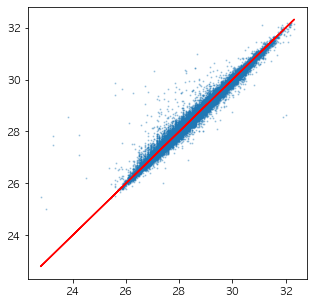

In [234]:
print('The accuracy of the stacking ensemble is',r2_score(final_y_test,y_pred))
print ('RMSE is: ', mean_squared_error(final_y_test, y_pred)**0.5)
print('\n')
fig = plt.figure(figsize=(5,5))
plt.scatter(final_y_test,y_pred, alpha=0.3, s=1)
plt.plot(final_y_test,final_y_test,'r')
plt.show()

In [224]:
metaModel.feature_importances_

array([0.00142014, 0.00149751, 0.00262957, 0.00194533, 0.00188979,
       0.20053724, 0.00304976, 0.78703067])

The accuracy of the stacking ensemble is 0.9838147386982227
RMSE is:  40910049.835471705




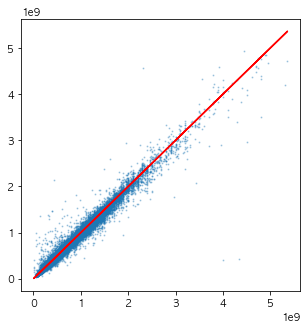

In [236]:
print('The accuracy of the stacking ensemble is',r2_score(np.exp2(final_y_test),np.exp2(y_pred)))
print ('RMSE is: ', mean_squared_error(np.exp2(final_y_test), np.exp2(y_pred))**0.5)
print('\n')

fig = plt.figure(figsize=(5,5))
plt.scatter(np.exp2(final_y_test),np.exp2(y_pred), alpha=0.3, s=1)
plt.plot(np.exp2(final_y_test),np.exp2(final_y_test),'r')
plt.show()

The accuracy of the stacking ensemble is 0.9841435001003048
RMSE is:  40492427.70685848




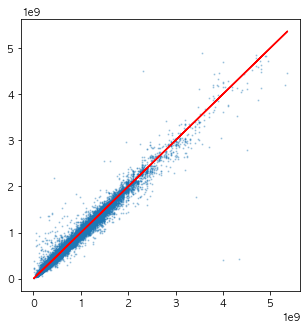

In [240]:
# 메타 모델 학습 2
metaModel5 = XGBRegressor(max_depth=6).fit(final_X_train, final_y_train)
y_pred = metaModel5.predict(final_X_test)

print('The accuracy of the stacking ensemble is',r2_score(np.exp2(final_y_test),np.exp2(y_pred)))
print ('RMSE is: ', mean_squared_error(np.exp2(final_y_test), np.exp2(y_pred))**0.5)
print('\n')

fig = plt.figure(figsize=(5,5))
plt.scatter(np.exp2(final_y_test),np.exp2(y_pred), alpha=0.3, s=1)
plt.plot(np.exp2(final_y_test),np.exp2(final_y_test),'r')
plt.show()

In [262]:
print('The accuracy of the stacking ensemble is',r2_score(final_y_test,y_pred))
print ('RMSE is: ', mean_squared_error(final_y_test, y_pred)**0.5)
print('\n')

The accuracy of the stacking ensemble is 0.9861159108232932
RMSE is:  0.09877526979811664


